In [1]:
import PIL
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import chain
import math
import random
import os
from scipy.misc import imresize
from mammo_utils import remove_white_from_image, slice_normal_image, create_slices, read_pgm, get_roi_edges, get_fuzzy_offset, get_roi_edges, random_flip_image, progress, extract_slice
%matplotlib inline

This notebook attempts to slice the MIAS images in the same way as the DDSM and CBIS-DDSM images were sliced, so that the models can be evaluated on the MIAS data. The code that could not be directly reused was cut-and-pasted with as little modfication as possible to maintain consistency.

In [158]:
def get_image_class(df, idx):
     # get the name of the image from the data
    img_name = df.loc[idx]['path']
    severity = df.loc[idx]['SEVERITY']
    img_class = df.loc[idx]['CLASS']
    
    if severity == "M":
        img_label = "MALIGNANT_"
        if img_class == "NORM":
            img_label = "NORMAL"
        elif img_class == "CALC":
            img_label = img_label + "calcification"
        else:
            img_label = img_label + "mass"
    elif severity == "B":
        img_label = "BENIGN_"
        if img_class == "CALC":
            img_label = img_label + "calcification"
        elif img_class == "NORM":
            img_label = "NORMAL"
        else:
            img_label = img_label + "mass"
    else:
        img_label = "NORMAL"
    
    return img_label

def trim_image_margins(img):
    img_h = img.shape[0]
    img_w = img.shape[1]
    
    # get which columns are all black
    black_pixels = np.sum(img == 0, axis=0)
    
    blank_cols = (black_pixels >= (img_h - 10))
    
    # first trim from the left
    first_col = np.argmax(~blank_cols)
    
    # now trim from the right
    last_col = img_w - np.argmax(~np.flip(blank_cols, axis=0))
    #last_col = 0
    
    img = img[:,first_col:last_col]
    
    return img, first_col, last_col
    
def get_random_scale(scale_by):
    # get the random factor
    random_scale_by = np.random.normal(loc=scale_by, scale=(scale_by * 0.4), size=None)
    
    # if the scale by is within a range return it, else keep trying until it is within the range
    if (random_scale_by > 1.5) and (random_scale_by < 2.75):
        return random_scale_by
    else:
        return get_random_scale(scale_by)
    
## Copy of function used to crop cbis images, but altered to deal with MIAS images
## returns: numpy array of images and list of corresponding file names
def create_mias_slices(df, pgm_dir="E:\\Documents\\Mammography\\MIAS\\pgms\\", scale_by=2.2, slice_size=299, var_upper_threshold=2000, var_lower_threshold=20, mean_threshold=38, debug=None):
    # loop through rows in the data frame
    slices_list = []
    image_names_list = []
    labels_list = []
    full_slice_size = slice_size
    
    counter = 0
    if debug is None:
        progress(counter, len(df), 'WORKING')
    
    for index, row in all_cases_df.iterrows():
        
        # get the base file name from the mask name
        image_name = row['path']
        
        # create a progress bar
        counter += 1
        if debug is None:
            progress(counter,  len(df), image_name)
            
        # try to open the image, if it doesn't exist continue
        try:
            full_image_arr = read_pgm(pgm_dir + image_name)
        except:
            print(image_name, "file not found!")
            continue       
        
        # get rid of the extra dimensions with unneccessary info
        image_h, image_w = full_image_arr.shape
        
        ## let's try extracting the ROI at size and then scaling it after it's been extracted
        # scale the image up by scale_by so it's on the same scale as the CBIS images
#         new_size = int(image_h * random_scale_by)
#         full_image_arr = imresize(full_image_arr, (new_size, new_size))

        # get the new shape of the image
        image_h, image_w = full_image_arr.shape
            
        # get the class of the image
        image_class = get_image_class(df, index)
        if debug is True:
            print(image_name, image_class)
        
        # if the image is abnormal
        if image_class != "NORMAL":            
            if debug is True:
                print(image_name, "abnormal")
            
            # if the image doesn't have ROI data skip it
            if np.isnan(row['X']):
                continue
            
            # get the size and shape of the ROI, NOT offset by the number of columns trimmed off
            center_col = int(row['X'])# * scale_by)
            center_row = image_h - int(row['Y'])# * scale_by)

            # the ROI is square so we don't need to get the sizes individually
            roi_size = mask_height = mask_width = mask_size = row['RADIUS'] * scale_by

            #####################################################################################
            ## extract the ROI with context size equal to double ROI size and random augmentation
            if debug:
                print("Adding ROI at size", image_name)

            img_slice = extract_slice(full_image_arr, center_col, center_row, roi_size, padding=1.2, context_scale=2, return_slice_size=299, distort=False)

            if img_slice.shape == (299,299, 1):
                slices_list.append(img_slice)
                image_names_list.append(image_name)
                labels_list.append(image_class)

            ####################################################################################
            ## Extract the ROI with a smaller margins
            img_slice = extract_slice(full_image_arr, center_col, center_row, roi_size, padding=1.3, context_scale=1.5, return_slice_size=299, distort=False)

            if img_slice.shape == (299,299, 1):
                slices_list.append(img_slice)
                image_names_list.append(image_name)
                labels_list.append(image_class)

            # if the slice is the right shape add it to the list
            if img_slice.shape == (slice_size,slice_size):
                slices_list.append(random_flip_image(img_slice.reshape(slice_size,slice_size,1)))
                image_names_list.append(image_name)
                labels_list.append(image_class)
            elif debug is not None:
                print("Actual size slice is wrong shape", image_name)
                
        ## ELse if the image is normal
        else:
            if debug is not None:
                print(image_name, " creating tiles")
            
            ## now we have to resize the image so the normal tiles are on the same scale
            new_size = int(image_h * scale_by)
            full_image_arr = imresize(full_image_arr, (new_size, new_size))
            
            # remove the margins
            full_image_arr, _, _ = trim_image_margins(full_image_arr)
            
            # slice the image into 299x299 tiles
            size = 299
            stride = 200
            tiles = [full_image_arr[x:x+size,y:y+size] for x in range(0,full_image_arr.shape[0],stride) for y in range(0,full_image_arr.shape[1],stride)]
            usable_tiles = []

            # for each tile:
            for i in range(len(tiles)):
                # make sure tile has correct shape
                if tiles[i].shape == (size,size):
                    # make sure the tile doesn't have too many white or black pixels, that indicates it is not useful
                    if (np.sum(np.sum(tiles[i] >= 225)) < 100) and (np.sum(np.sum(tiles[i] <= 20)) <= 50000):
                        # make sure tile has stuff in it
                        if np.mean(tiles[i]) >= mean_threshold:
                            # make sure the tile contains image and not mostly empty space
                            if np.var(tiles[i]) <= var_upper_threshold:
                                if np.var(tiles[i]) >= var_lower_threshold:
                                    # flip a coin to decide whether to include the tile
                                    coin = np.random.binomial(1, 0.3)
                                    if coin:
                                        # reshape the tile so they will work with the convnet
                                        slices_list.append(random_flip_image(tiles[i].reshape(299,299,1)))
                                        image_names_list.append(image_name)
                                        labels_list.append(image_class)

    return np.array(slices_list), np.array(labels_list), image_names_list

In [159]:
# import and clean the annotation data, this time leave the duplicates
all_cases_df = pd.read_table('data/Info.txt', delimiter=' ')
all_cases_df = all_cases_df[all_cases_df.columns[:-1]] # drop last column
all_cases_df['path'] = all_cases_df['REFNUM'].map(lambda x: '%s.pgm' % x)

In [160]:
slices, labels, filenames = create_mias_slices(all_cases_df, debug=True)

mdb001.pgm BENIGN_mass
mdb001.pgm abnormal
Adding ROI at size mdb001.pgm
Actual size slice is wrong shape mdb001.pgm
mdb002.pgm BENIGN_mass
mdb002.pgm abnormal
Adding ROI at size mdb002.pgm
Actual size slice is wrong shape mdb002.pgm
mdb003.pgm NORMAL
mdb003.pgm  creating tiles
mdb004.pgm NORMAL
mdb004.pgm  creating tiles


C:\Users\eric\Anaconda2\envs\exts-aml2\lib\site-packages\scipy\misc\pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if issubdtype(ts, int):
C:\Users\eric\Anaconda2\envs\exts-aml2\lib\site-packages\scipy\misc\pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


mdb005.pgm BENIGN_mass
mdb005.pgm abnormal
Adding ROI at size mdb005.pgm
Actual size slice is wrong shape mdb005.pgm
mdb005.pgm BENIGN_mass
mdb005.pgm abnormal
Adding ROI at size mdb005.pgm
Actual size slice is wrong shape mdb005.pgm
mdb006.pgm NORMAL
mdb006.pgm  creating tiles
mdb007.pgm NORMAL
mdb007.pgm  creating tiles
mdb008.pgm NORMAL
mdb008.pgm  creating tiles
mdb009.pgm NORMAL
mdb009.pgm  creating tiles
mdb010.pgm BENIGN_mass
mdb010.pgm abnormal
Adding ROI at size mdb010.pgm
Actual size slice is wrong shape mdb010.pgm
mdb011.pgm NORMAL
mdb011.pgm  creating tiles
mdb012.pgm BENIGN_mass
mdb012.pgm abnormal
Adding ROI at size mdb012.pgm
Actual size slice is wrong shape mdb012.pgm
mdb013.pgm BENIGN_mass
mdb013.pgm abnormal
Adding ROI at size mdb013.pgm
Actual size slice is wrong shape mdb013.pgm
mdb014.pgm NORMAL
mdb014.pgm  creating tiles
mdb015.pgm BENIGN_mass
mdb015.pgm abnormal
Adding ROI at size mdb015.pgm
Actual size slice is wrong shape mdb015.pgm
mdb016.pgm NORMAL
mdb016.pgm

mdb130.pgm MALIGNANT_mass
mdb130.pgm abnormal
Adding ROI at size mdb130.pgm
Actual size slice is wrong shape mdb130.pgm
mdb131.pgm NORMAL
mdb131.pgm  creating tiles
mdb132.pgm BENIGN_mass
mdb132.pgm abnormal
Adding ROI at size mdb132.pgm
Actual size slice is wrong shape mdb132.pgm
mdb132.pgm BENIGN_mass
mdb132.pgm abnormal
Adding ROI at size mdb132.pgm
Actual size slice is wrong shape mdb132.pgm
mdb133.pgm NORMAL
mdb133.pgm  creating tiles
mdb134.pgm MALIGNANT_mass
mdb134.pgm abnormal
Adding ROI at size mdb134.pgm
Actual size slice is wrong shape mdb134.pgm
mdb135.pgm NORMAL
mdb135.pgm  creating tiles
mdb136.pgm NORMAL
mdb136.pgm  creating tiles
mdb137.pgm NORMAL
mdb137.pgm  creating tiles
mdb138.pgm NORMAL
mdb138.pgm  creating tiles
mdb139.pgm NORMAL
mdb139.pgm  creating tiles
mdb140.pgm NORMAL
mdb140.pgm  creating tiles
mdb141.pgm MALIGNANT_mass
mdb141.pgm abnormal
Adding ROI at size mdb141.pgm
Actual size slice is wrong shape mdb141.pgm
mdb142.pgm BENIGN_mass
mdb142.pgm abnormal
Add

mdb227.pgm BENIGN_calcification
mdb227.pgm abnormal
Adding ROI at size mdb227.pgm
Actual size slice is wrong shape mdb227.pgm
mdb228.pgm NORMAL
mdb228.pgm  creating tiles
mdb229.pgm NORMAL
mdb229.pgm  creating tiles
mdb230.pgm NORMAL
mdb230.pgm  creating tiles
mdb231.pgm MALIGNANT_calcification
mdb231.pgm abnormal
Adding ROI at size mdb231.pgm
Actual size slice is wrong shape mdb231.pgm
mdb232.pgm NORMAL
mdb232.pgm  creating tiles
mdb233.pgm MALIGNANT_calcification
mdb233.pgm abnormal
mdb234.pgm NORMAL
mdb234.pgm  creating tiles
mdb235.pgm NORMAL
mdb235.pgm  creating tiles
mdb236.pgm BENIGN_calcification
mdb236.pgm abnormal
Adding ROI at size mdb236.pgm
Actual size slice is wrong shape mdb236.pgm
mdb237.pgm NORMAL
mdb237.pgm  creating tiles
mdb238.pgm MALIGNANT_calcification
mdb238.pgm abnormal
Adding ROI at size mdb238.pgm
Actual size slice is wrong shape mdb238.pgm
mdb239.pgm MALIGNANT_calcification
mdb239.pgm abnormal
Adding ROI at size mdb239.pgm
Actual size slice is wrong shape md

In [161]:
print("Slices:", slices.shape)
print("Labels:", labels.shape)
print("Filenames:", len(filenames))

Slices: (2119, 299, 299, 1)
Labels: (2119,)
Filenames: 2119


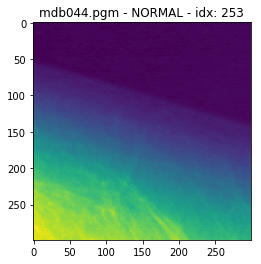

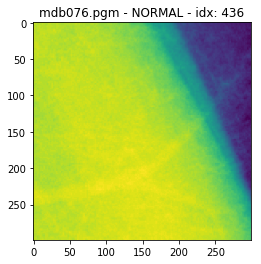

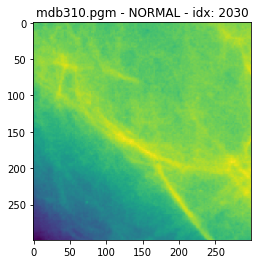

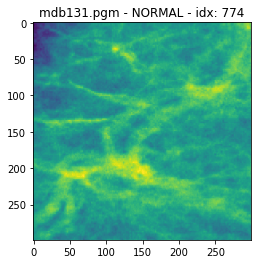

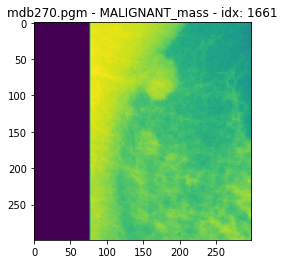

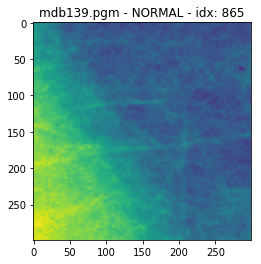

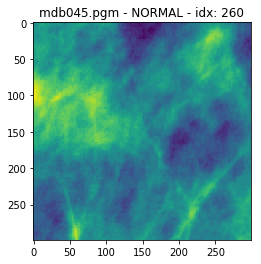

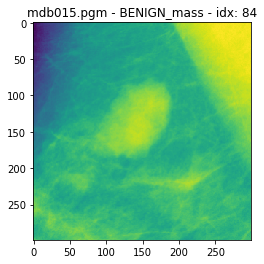

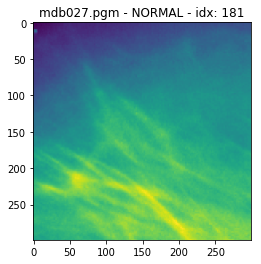

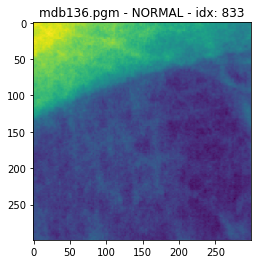

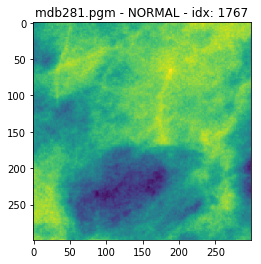

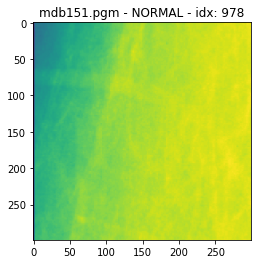

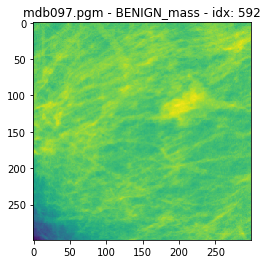

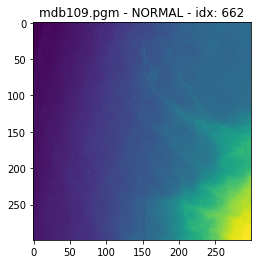

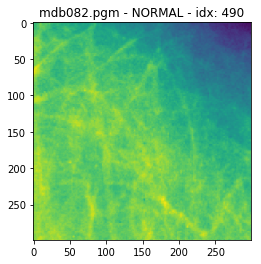

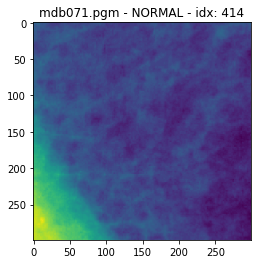

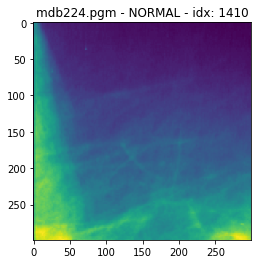

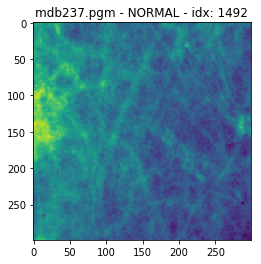

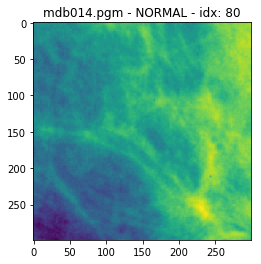

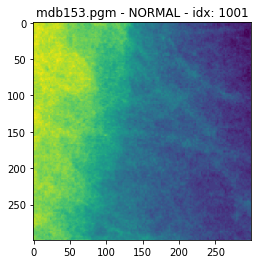

In [162]:
# look at some random images
N = 20
idxs = random.sample(range(len(slices)), k=N)

for idx in idxs:
    plt.imshow(slices[idx].reshape(299,299))
    plt.title(filenames[idx] + " - " + labels[idx] + " - idx: " + str(idx))
    plt.show()

In [163]:
pd.value_counts(labels, normalize=True)

NORMAL                     0.887683
BENIGN_mass                0.050024
MALIGNANT_mass             0.036810
BENIGN_calcification       0.014158
MALIGNANT_calcification    0.011326
dtype: float64

In [164]:
# encode the labels
from sklearn import preprocessing

# load the classes used to encode the other data
classes = np.load(os.path.join("data", "all_classes.npy"))

# create the encoder
le = preprocessing.LabelEncoder()
le.fit(labels)

# we want normal to be 0, so we'll do some transformations here
labels_enc = le.transform(labels) + 1
labels_enc[labels_enc == 5] = 0

# make sure the classes match how the other labels were encoded
mias_classes = le.classes_
mias_classes = np.insert(mias_classes, 0, 'NORMAL', axis=0)
mias_classes = mias_classes[0:5]

print("MIAS Classes", mias_classes)
print("Training Classes", classes)

MIAS Classes ['NORMAL' 'BENIGN_calcification' 'BENIGN_mass' 'MALIGNANT_calcification'
 'MALIGNANT_mass']
Training Classes ['NORMAL' 'BENIGN_calcification' 'BENIGN_mass' 'MALIGNANT_calcification'
 'MALIGNANT_mass']


In [165]:
## save the data
np.save(os.path.join("data", "all_mias_slices.npy"), slices)
np.save(os.path.join("data", "all_mias_labels.npy"), labels_enc)
np.save(os.path.join("data", "all_mias_filenames.npy"), filenames)